# Simple example of Grad-CAM

## Overview of Grad-CAM
![title](grad-cam_overview.png)

In [1]:
import math
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import Inception_resnet
import tensorflow.contrib.slim as slim
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops

c:\programdata\anaconda3\envs\cf_1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\programdata\anaconda3\envs\cf_1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\programdata\anaconda3\envs\cf_1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\programdata\anaconda3\envs\cf_1\lib\site-packages\tensorflow\python\frame

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




In [2]:
tf.VERSION

'1.14.0'

In [3]:
tf.set_random_seed(0)

In [4]:
def print_prob(prob, file_path):
    synset = [l.strip() for l in open(file_path).readlines()]
    #print(synset)
    pred = np.argsort(prob)[::-1]

    # Get top1 label
    top1 = synset[pred[0]]
    print("Top1: ", top1, prob[pred[0]])
    # Get top5 label
    #top5 = [(synset[pred[i]], prob[pred[i]]) for i in range(5)]
    #print("Top5: ", top5)
    return top1

In [5]:
def calc_cam(feature_map_Activations_value, grad_feature_map_Actvations_value, guided_backprop_grad_value):
    
    ##############################
    ###        grad-CAM        ###
    ##############################
    cam = np.zeros(feature_map_Activations_value.shape[0 : 2], dtype = np.float32)
    # Global average pooling
    weights_alpha = np.mean(grad_feature_map_Actvations_value, axis = (0, 1))
    # Taking a weighted average
    for i, w in enumerate(weights_alpha):
        cam += w * feature_map_Activations_value[:, :, i]
    # Passing through ReLU
    cam = np.maximum(cam, 0)
    # Normalize
    cam = cam / np.max(cam) # scale 0 to 1.0
    cam = cv2.resize(cam, (299,299))
    # Express as heatmap
    cam_heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    cam_heatmap = cv2.cvtColor(cam_heatmap, cv2.COLOR_BGR2RGB)
    
    
    ##############################
    ###     guided grad-CAM    ###
    ##############################
    # guided grad-CAM = guided backprop * grad-CAM
    # Normalize
    guided_backprop_grad_value -= np.min(guided_backprop_grad_value)
    guided_backprop_grad_value /= guided_backprop_grad_value.max()
    guided_backprop_grad_cam = np.dstack((
            guided_backprop_grad_value[:, :, 0] * cam,
            guided_backprop_grad_value[:, :, 1] * cam,
            guided_backprop_grad_value[:, :, 2] * cam,
        ))
    
    return cam_heatmap, guided_backprop_grad_value, guided_backprop_grad_cam

In [6]:
### SET PARAMETERS 
class_num = 1001
class_txt =  './synset.txt'
# latest_checkpoint = 'checkpoint/CLASSIFICATION'
latest_checkpoint = 'checkpoint/inception_resnet_v2.ckpt'
layer_name =  'Conv2d_7b_1x1' # 50x50 #'Conv2d_1a_3x3'#
target = 0
batch_size = 8
output_path = './result/'
input_dir_path = './input'

if not os.path.exists(output_path):
    os.makedirs(output_path)

In [7]:
@ops.RegisterGradient("GuidedRelu")
def _GuidedReluGrad(op, grad):
    return tf.where(0. < grad, gen_nn_ops.relu_grad(grad, op.outputs[0]), tf.zeros(grad.get_shape()))

In [8]:
eval_graph = tf.Graph()
eval_graph.gradient_override_map({'Relu': 'GuidedRelu'})

In [9]:
images = tf.placeholder(tf.float32, [batch_size, 299, 299, 3])
labels = tf.placeholder(tf.float32, [batch_size, class_num])
is_training = tf.placeholder(tf.bool, name='is_training')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

In [11]:
with slim.arg_scope(Inception_resnet.inception_resnet_v2_arg_scope()):
    with slim.arg_scope([slim.batch_norm], is_training=False):
        net, end_points = Inception_resnet.inception_resnet_v2(images, class_num, is_training=is_training, dropout_keep_prob=keep_prob)
prob = end_points['Predictions']


Instructions for updating:
Use keras.layers.flatten instead.


In [12]:
cost = tf.nn.softmax_cross_entropy_with_logits(labels = labels,logits = net)
y_c = tf.reduce_sum(tf.multiply(net, labels), axis=1) # Score for class c (before softmax)

feature_map_Activations = end_points[layer_name]
grad_feature_map_Actvations = tf.gradients(ys = y_c, xs = feature_map_Activations)[0]
guided_backprop_grad = tf.gradients(cost, images)[0]

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [13]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)
saver = tf.train.Saver(tf.global_variables())
saver.restore(sess, latest_checkpoint)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoint/inception_resnet_v2.ckpt


In [14]:
## LOAD IMAGES

images_list = [i for i in os.listdir(input_dir_path) if 'jpg' in i]
print('List of Images : ',images_list)

batch_img = []
batch_label = []
for i in images_list:
    img = cv2.imread(input_dir_path+'/'+i)
    img = cv2.resize(img, (299,299))
    img = img.reshape((299, 299, 3))
    label = np.array([1 if i == target else 0 for i in range(class_num)])
    batch_img.append(img)
    batch_label.append(label)

List of Images :  ['w08ee1703b_-420287_-385396_af.jpg', 'w08ee1703b_-420350_-385259_af.jpg', 'w08ee1703b_-869695_63597_af.jpg', 'w08ee1704a_133419_251384_af.jpg', 'w08ee1704a_145997_504941_af.jpg', 'w08ee1704a_357930_504377_af.jpg', 'w08ee1704a_566340_-240152_af.jpg', 'w08ee1704a_96410_320901_af.jpg']


In [15]:
# Run!
net_1, prob_1, guided_backprop_grad_value, feature_map_Activations_value, grad_feature_map_Actvations_value = sess.run([net, prob, guided_backprop_grad, feature_map_Activations, grad_feature_map_Actvations], feed_dict={images: batch_img, labels: batch_label, is_training:True, keep_prob:0.5})    

In [17]:
# calc per image
num = 7
for x in range(num):
    #print_prob(prob_1[x], class_txt)
    cam_heatmap, guided_backprop, guided_backprop_grad_cam = calc_cam(feature_map_Activations_value[x], grad_feature_map_Actvations_value[x], guided_backprop_grad_value[x])

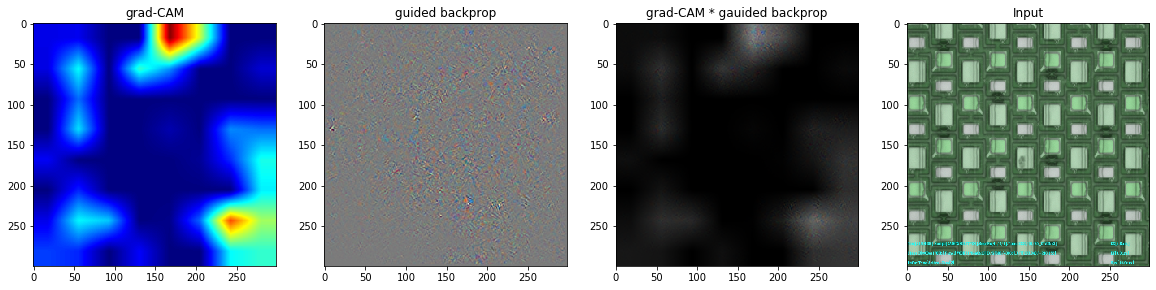

In [18]:
fig = plt.figure(figsize=(20,10))
ax_list = []
for i in range(1,5):
    ax_list.append(fig.add_subplot(1, 4, i))

ax_list[0].imshow(cam_heatmap)
ax_list[0].set_title('grad-CAM')
ax_list[1].imshow(guided_backprop)
ax_list[1].set_title('guided backprop')
ax_list[2].imshow(guided_backprop_grad_cam)
ax_list[2].set_title('grad-CAM * gauided backprop')
ax_list[3].imshow(batch_img[num-1])
ax_list[3].set_title('Input')
plt.show()

In [141]:
test_img = guided_backprop_grad_cam*batch_img[num-1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


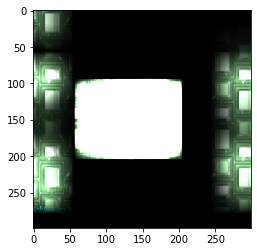

In [142]:
plt.imshow(test_img)

In [146]:
np.shape(batch_img[num-1])

(299, 299, 3)

In [147]:
np.shape(guided_backprop_grad_cam)

(299, 299, 3)